In [1]:
cd ..

/home/janek/mag/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
import random
from sklearn import metrics
from src.reasoner_mod import *
from src.generate import load_dataset, prepare_data, reduce_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *


In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)


In [4]:
data_tr, data_vl, data_tr_p2, data_vl_p2, idx_te, X_te, y_te = prepare_data(data_tr, data_vl, data_te, seed, 5)

In [5]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_tr_p2[2]))
print(np.mean(data_vl_p2[2]))
print(np.mean(y_te))

0.21888727203492406
0.191374246405936

0.2203348305430788
0.18243243243243243
0.18631643249847282


In [6]:
print(len(data_tr[2]))
print(len(data_vl[2]))
print()
print(len(data_tr_p2[2]))
print(len(data_vl_p2[2]))
print(len(y_te))

73531
6469

36735
1628
1637


In [7]:
data_tr_p2 = reduce_dataset(data_tr_p2, len(test_onto), 1400, [idx_te, X_te, y_te])
data_tr = reduce_dataset(data_tr, len(train_onto), 1350, data_vl)
idx_te.extend(data_vl_p2[0])
X_te.extend(data_vl_p2[1])
y_te.extend(data_vl_p2[2])

In [8]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_tr_p2[2]))
print(np.mean(data_vl_p2[2]))
print(np.mean(y_te))

0.19148148148148147
0.191374246405936

0.18210714285714286
0.18243243243243243
0.18437978560490045


In [9]:
print(len(data_tr[2]))
print(len(data_vl[2]))
print()
print(len(data_tr_p2[2]))
print(len(y_te))

54000
6469

28000
1628
3265


In [10]:
emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32

In [11]:
#FIRST PHASE
T.manual_seed(seed)
reasoner_original = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders_original = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]
print(f'created reasoner with {paramcount(reasoner_original)} parameters')
print(f'created {len(encoders_original)} encoders with {paramcount(encoders_original[0])} parameters each')

T.manual_seed(seed)
reasoner_mod = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders_mod = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]
print(f'created reasoner with {paramcount(reasoner_mod)} parameters')
print(f'created {len(encoders_mod)} encoders with {paramcount(encoders_mod[0])} parameters each')

train_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('original reasoner', reasoner_original), ('modified reasoner', reasoner_mod)]:
    print(reasoner_name)
    T.manual_seed(seed)
    random.seed(seed)
    if reasoner_name == 'original reasoner':
        train(data_tr, data_vl, reasoner, encoders_original, epoch_count=epoch_count, batch_size=batch_size, run_name=reasoner_name, logger=train_logger)
    else:
        train_mod(data_tr, data_vl, reasoner, encoders_mod, epoch_count=epoch_count, batch_size=batch_size, run_name=reasoner_name, logger=train_logger, identities_weight=0.028, identitity_weight_decay=0.96)


created reasoner with 3293 parameters
created 40 encoders with 1270 parameters each
created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
original reasoner
train epoch 00/15 | batch 1689/1688 | loss 0.7228 | val loss 0.7222 | acc 0.1912 | f1 0.3210 | prec 0.1912 | recall 0.9992 | roc auc 0.5402 | pr auc 0.2211 | elapsed 15.35s
train epoch 01/15 | batch 1689/1688 | loss 0.5656 | val loss 0.4631 | acc 0.8182 | f1 0.1158 | prec 0.8370 | recall 0.0622 | roc auc 0.6420 | pr auc 0.3258 | elapsed 53.57s
train epoch 02/15 | batch 1689/1688 | loss 0.4377 | val loss 0.4213 | acc 0.8221 | f1 0.2541 | prec 0.6426 | recall 0.1583 | roc auc 0.7599 | pr auc 0.4662 | elapsed 52.68s
train epoch 03/15 | batch 1689/1688 | loss 0.3458 | val loss 0.3820 | acc 0.8474 | f1 0.4633 | prec 0.7088 | recall 0.3441 | roc auc 0.8136 | pr auc 0.6090 | elapsed 52.87s
train epoch 04/15 | batch 1689/1688 | loss 0.2703 | val loss 0.3558 | acc 0.8694 | f1 0.5839 | prec 0.7478 | recall 0.4790

In [12]:
## --- SECOND PHASE
trained_test_encoders = {}
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('original reasoner', reasoner_original), ('modified reasoner', reasoner_mod)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    if reasoner_name == 'original reasoner':
        train(data_tr_p2, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)
    else:
        train_mod(data_tr_p2, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)


original reasoner
train epoch 00/10 | batch 876/875 | loss 1.4245 | val loss 1.4245 | acc 0.5915 | f1 0.3577 | prec 0.2506 | recall 0.6244 | roc auc 0.6652 | pr auc 0.4495 | elapsed 9.12s
train epoch 01/10 | batch 876/875 | loss 1.2111 | val loss 0.9693 | acc 0.6825 | f1 0.4199 | prec 0.3147 | recall 0.6311 | roc auc 0.7284 | pr auc 0.5173 | elapsed 19.78s
train epoch 02/10 | batch 876/875 | loss 0.8218 | val loss 0.6482 | acc 0.7677 | f1 0.5042 | prec 0.4124 | recall 0.6486 | roc auc 0.7913 | pr auc 0.5991 | elapsed 20.41s
train epoch 03/10 | batch 876/875 | loss 0.5584 | val loss 0.4457 | acc 0.8363 | f1 0.5987 | prec 0.5408 | recall 0.6705 | roc auc 0.8459 | pr auc 0.6887 | elapsed 20.53s
train epoch 04/10 | batch 876/875 | loss 0.3949 | val loss 0.3229 | acc 0.8819 | f1 0.6822 | prec 0.6691 | recall 0.6958 | roc auc 0.8873 | pr auc 0.7700 | elapsed 19.91s
train epoch 05/10 | batch 876/875 | loss 0.2956 | val loss 0.2486 | acc 0.9126 | f1 0.7508 | prec 0.7805 | recall 0.7233 | roc a

In [13]:
with T.no_grad():
    _, _, Y_te_orig = eval_batch(reasoner_original, trained_test_encoders['original reasoner'], X_te, y_te, idx_te)
    _, _, Y_te_mod = eval_batch(reasoner_mod, trained_test_encoders['modified reasoner'], X_te, y_te, idx_te)

local/out/exp/20240808T171513


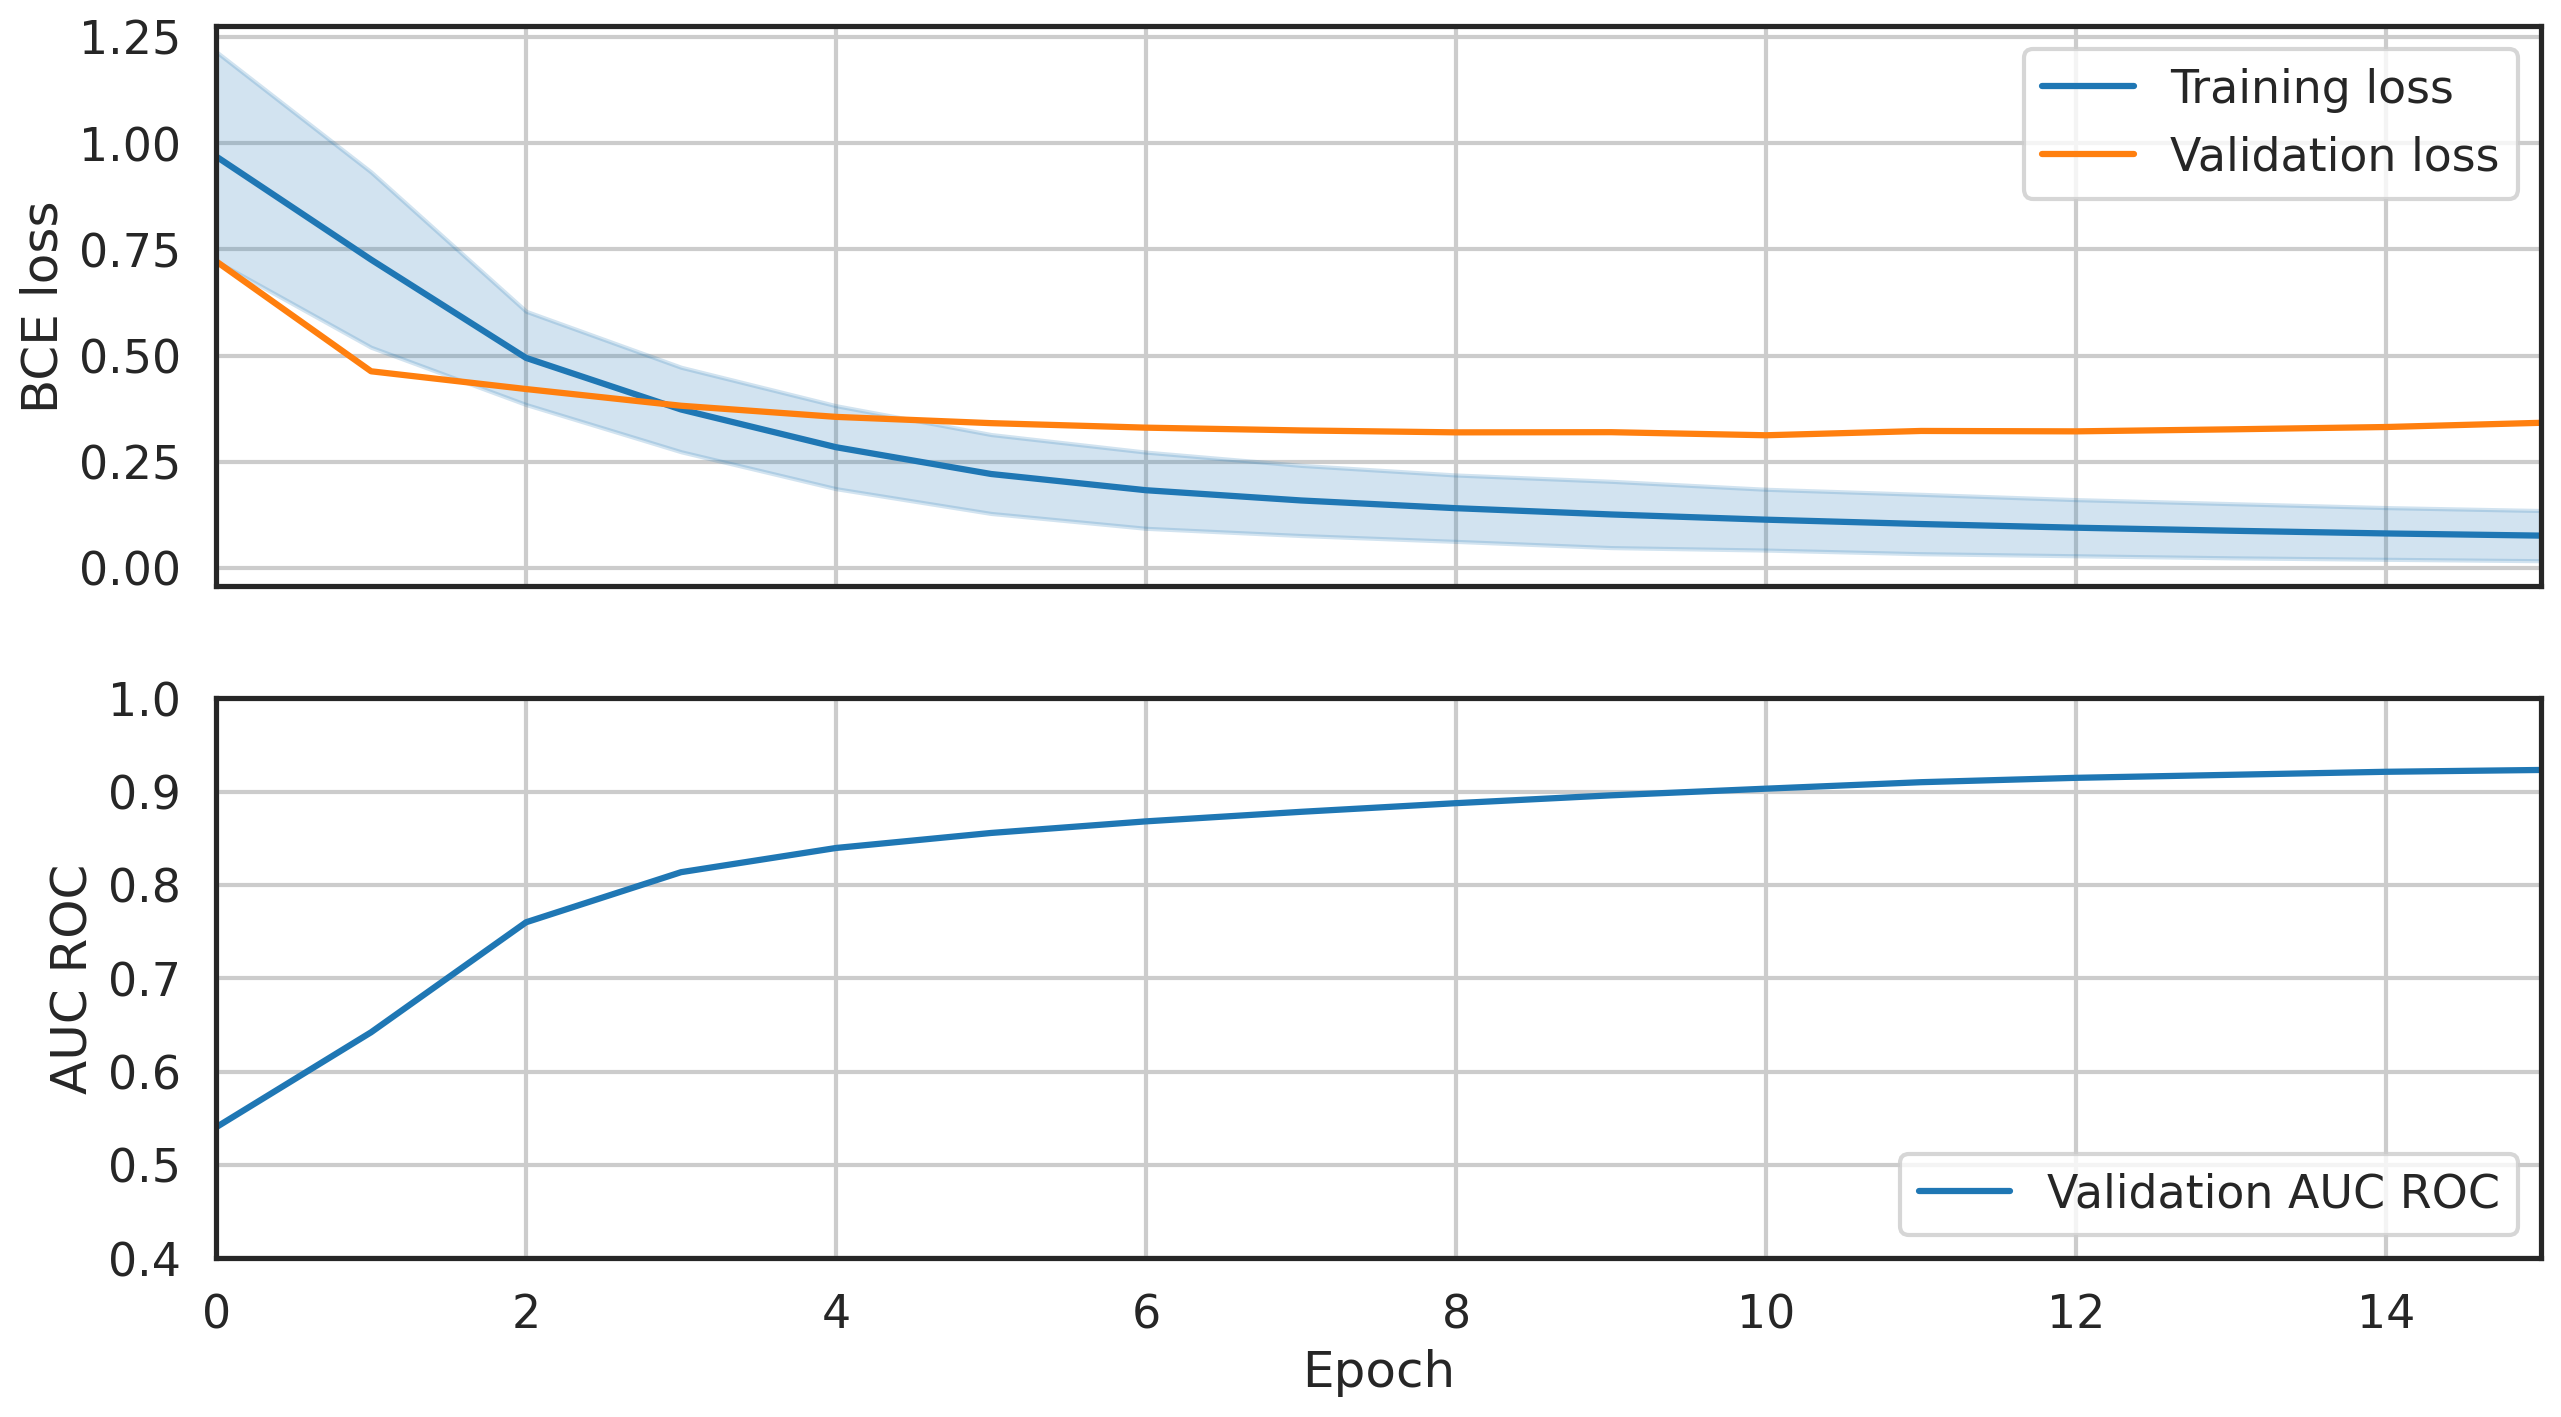

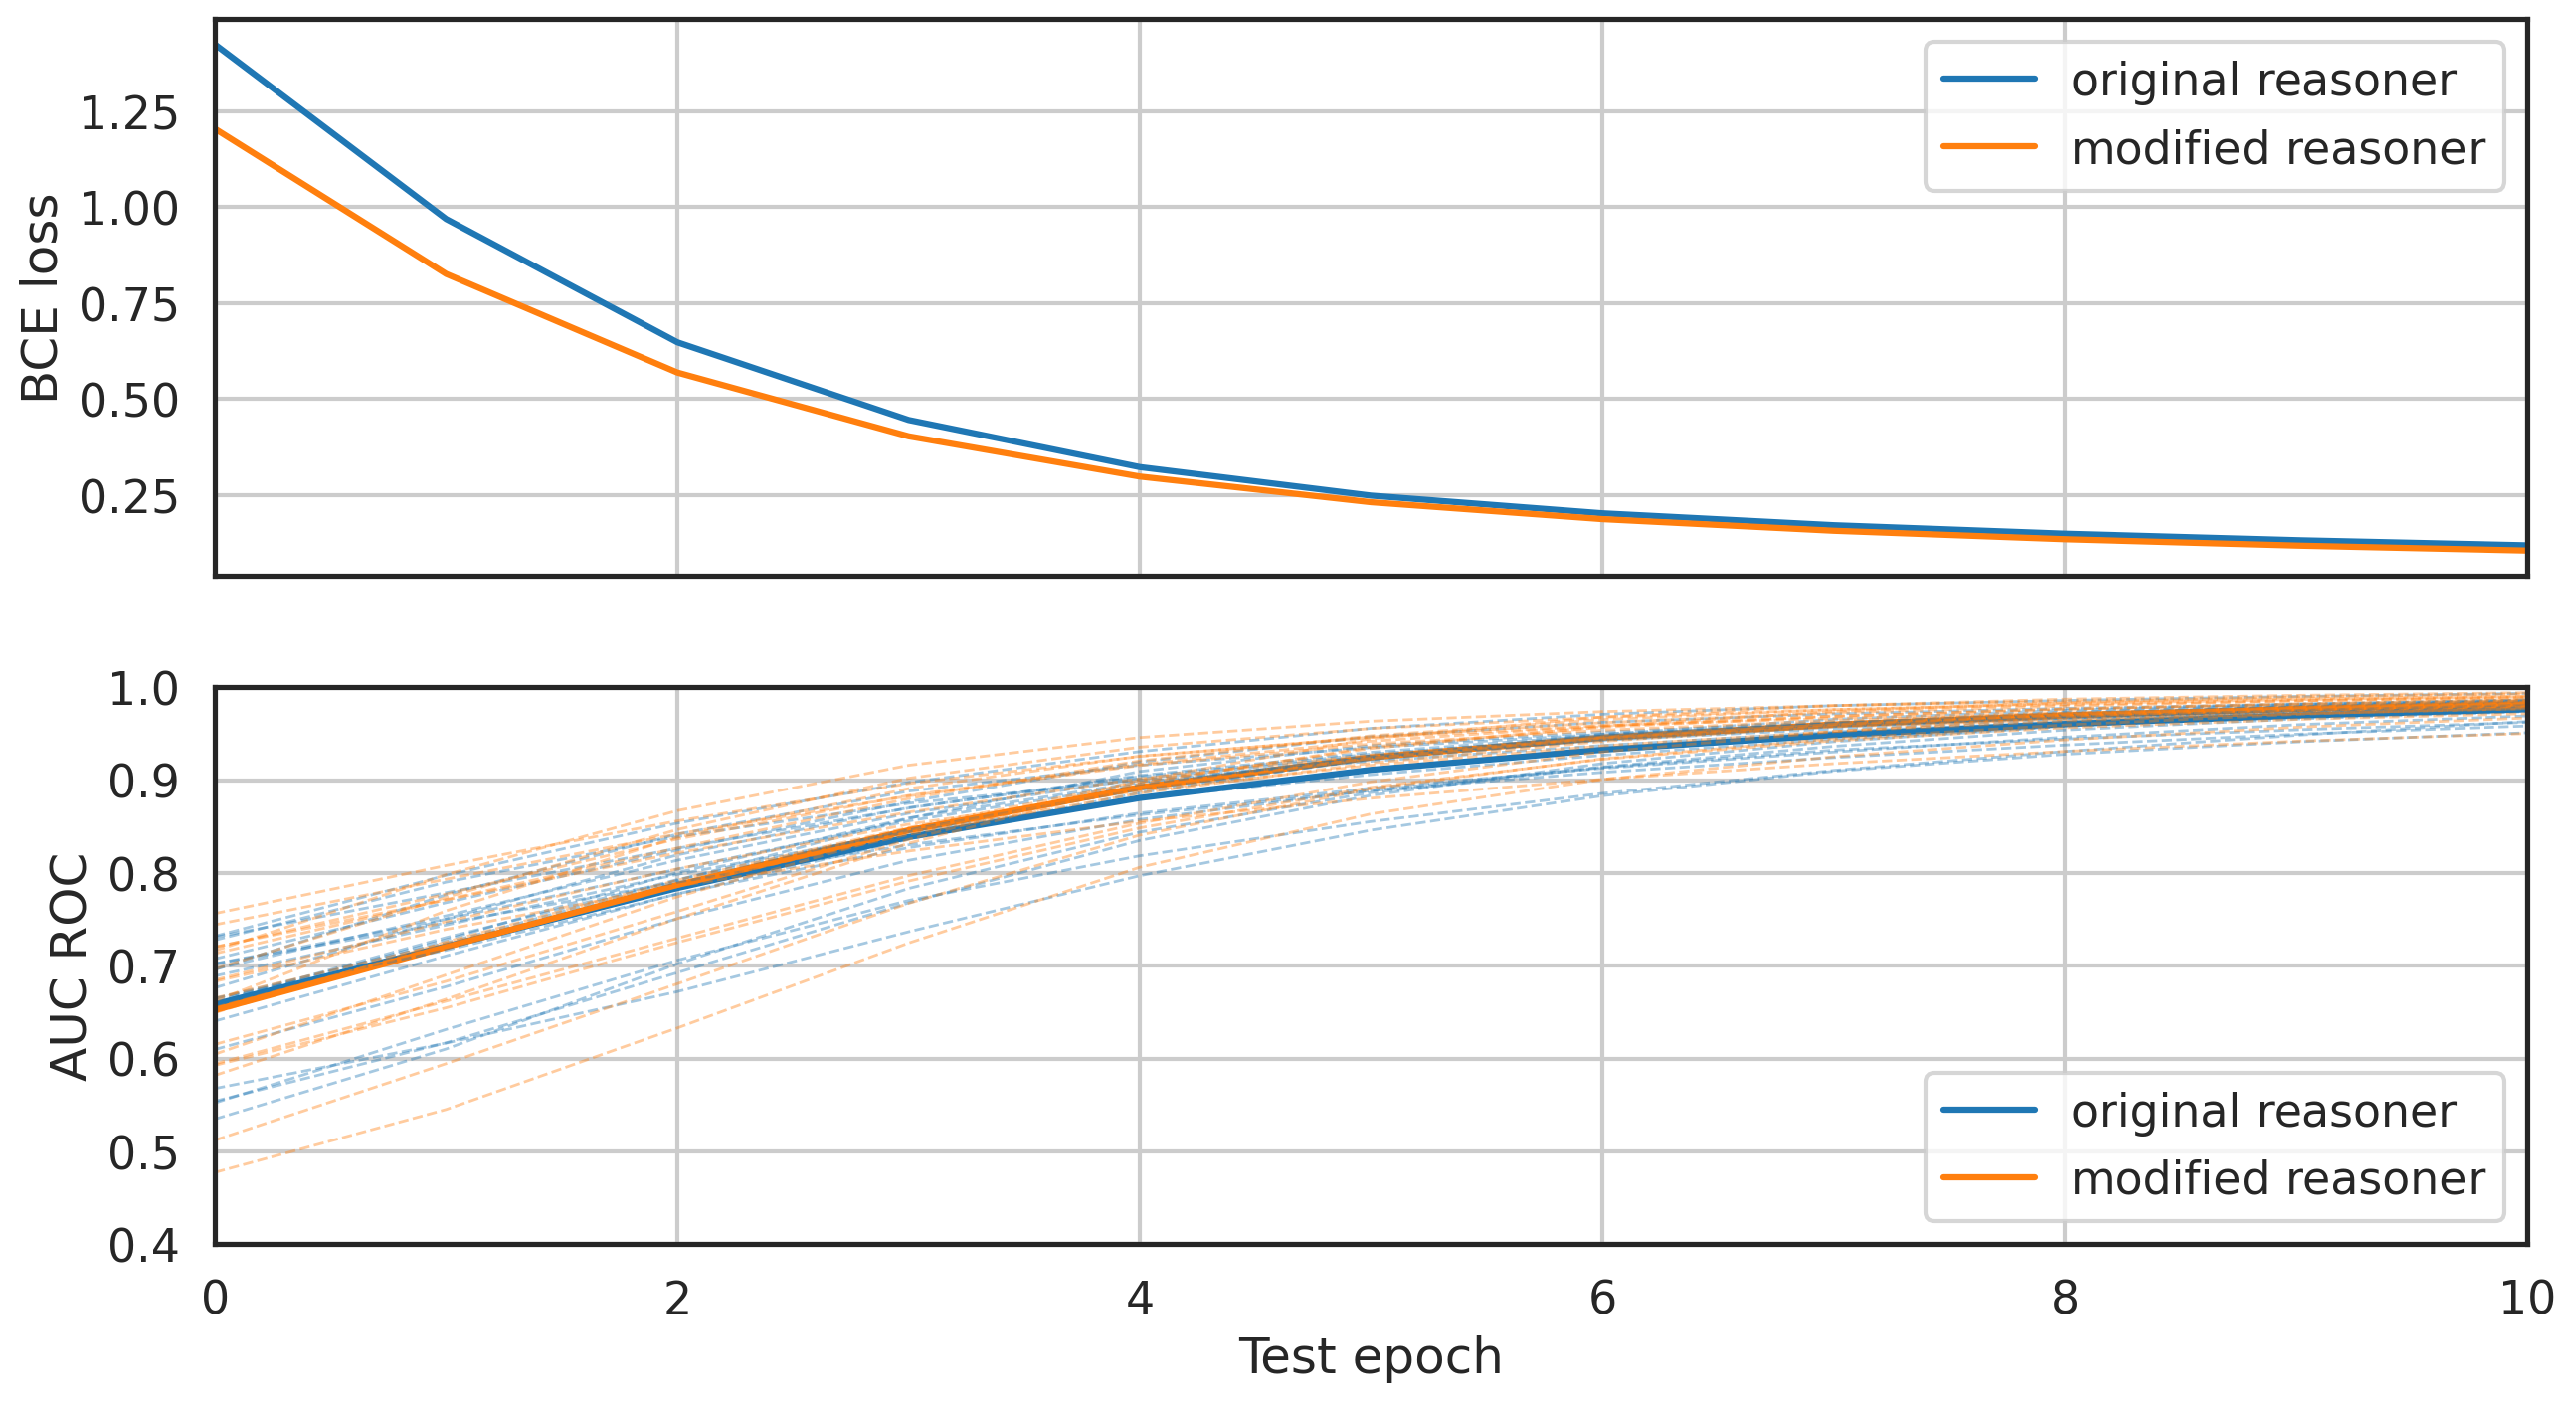

original
             mean       std     micro
acc      0.873934  0.043874  0.873507
prec     0.665484  0.131798  0.667257
recall   0.613850  0.133638  0.626246
f1       0.631033  0.112221  0.646101
auc_roc  0.863485  0.054797  0.869500
auc_pr   0.721862  0.105329  0.738347
modified
             mean       std     micro
acc      0.864075  0.031767  0.864012
prec     0.586418  0.109028  0.608219
recall   0.717528  0.114664  0.737542
f1       0.642227  0.104883  0.666667
auc_roc  0.891089  0.047766  0.896252
auc_pr   0.756774  0.103913  0.780444


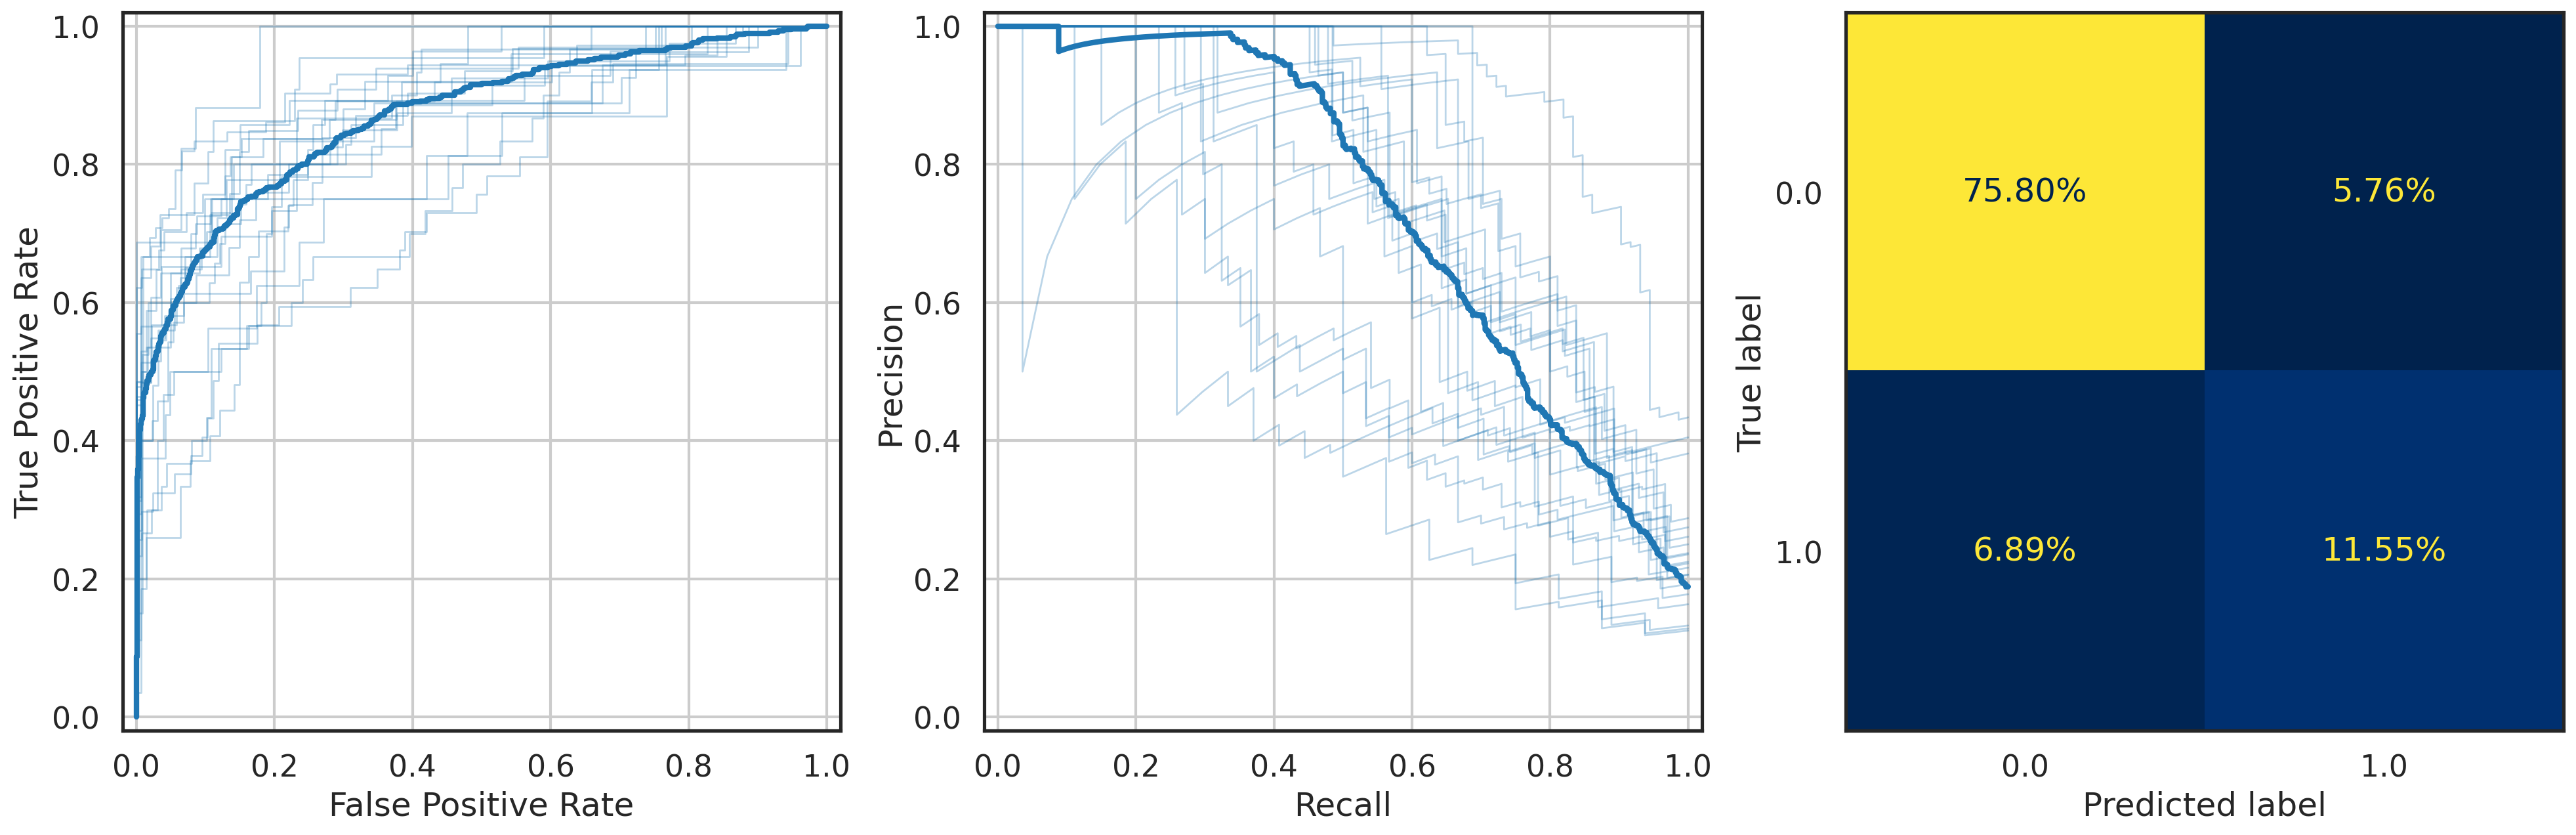

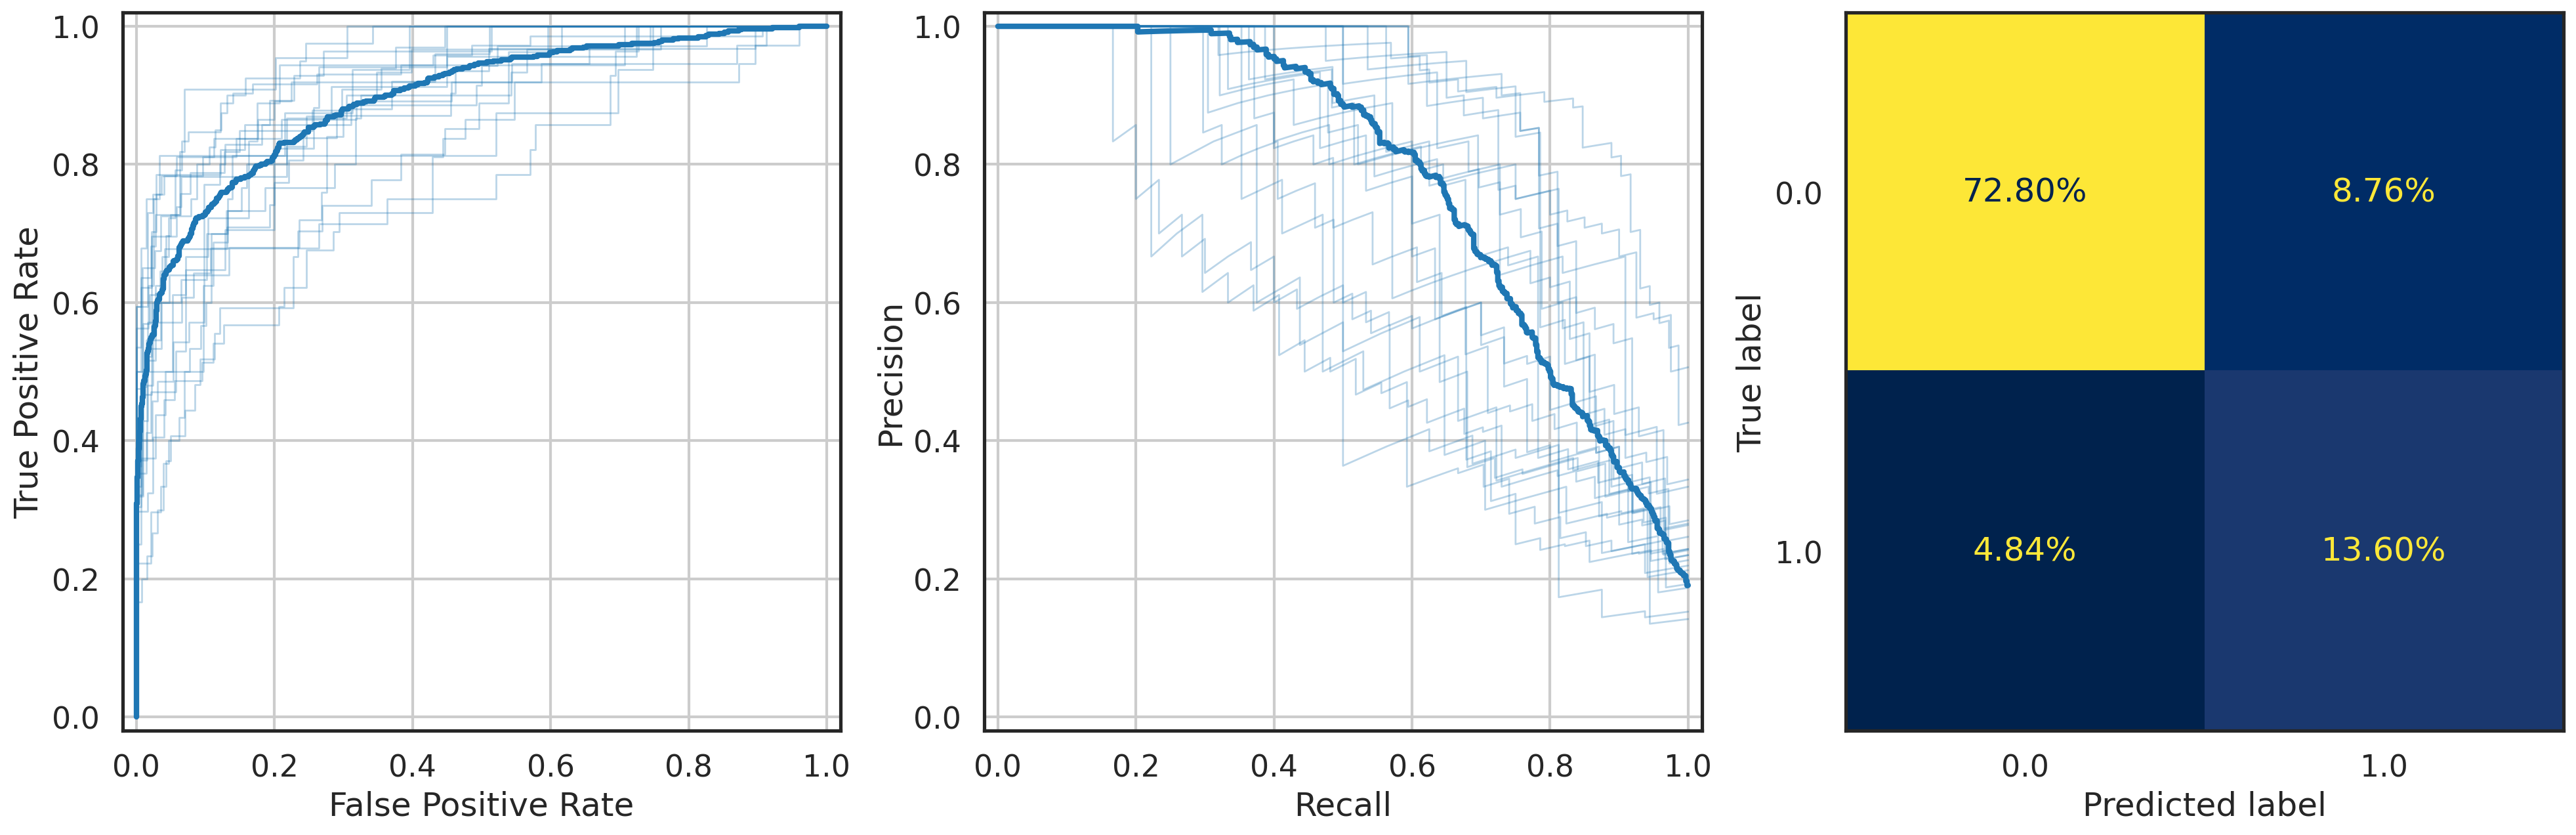

In [14]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(reasoner_original.state_dict(), base+'/reasonerO.pt')
T.save(reasoner_mod.state_dict(), base+'/reasonerM.pt')

df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_orig=Y_te_orig, Y_te_mod=Y_te_mod))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print('original')
print(report(test_onto, y_te, np.array(Y_te_orig), idx_te, save=base+'/%-trained'))
print('modified')
print(report(test_onto, y_te, np.array(Y_te_mod), idx_te, save=base+'/%-random'))

In [15]:
from src.id import print_identity_results
print(print_identity_results(reasoner_original,trained_test_encoders['original reasoner'], seed))

Double Negation:
  Mean Loss: 0.275991
  Std Dev Loss: 0.032176
  Mean Diff: 0.572118
  Std Dev Diff: 0.098630

Duality of Top and Bottom:
  Mean Loss: 0.375272
  Std Dev Loss: 0.000000
  Mean Diff: 0.763538
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.124936
  Std Dev Loss: 0.032035
  Mean Diff: 0.305764
  Std Dev Diff: 0.083122

Associativity:
  Mean Loss: 0.034341
  Std Dev Loss: 0.012388
  Mean Diff: 0.078152
  Std Dev Diff: 0.027059

Commutativity:
  Mean Loss: 0.037842
  Std Dev Loss: 0.012839
  Mean Diff: 0.088395
  Std Dev Diff: 0.032827

Contradiction:
  Mean Loss: 0.386013
  Std Dev Loss: 0.014239
  Mean Diff: 0.823729
  Std Dev Diff: 0.067258

Identity with Top:
  Mean Loss: 0.143644
  Std Dev Loss: 0.037096
  Mean Diff: 0.352561
  Std Dev Diff: 0.117304

Absorption by Bottom:
  Mean Loss: 0.447624
  Std Dev Loss: 0.019819
  Mean Diff: 0.839089
  Std Dev Diff: 0.043933

Top Concept Subsumption:
  Mean Loss: 0.001447
  Std Dev Loss: 0.001537
  Mean Diff: N/A
  Std De

In [16]:
print(print_identity_results(reasoner_mod,trained_test_encoders['modified reasoner'], seed))

Double Negation:
  Mean Loss: 0.000029
  Std Dev Loss: 0.000011
  Mean Diff: 0.000076
  Std Dev Diff: 0.000035

Duality of Top and Bottom:
  Mean Loss: 0.000255
  Std Dev Loss: 0.000000
  Mean Diff: 0.000465
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.116274
  Std Dev Loss: 0.028089
  Mean Diff: 0.269097
  Std Dev Diff: 0.075368

Associativity:
  Mean Loss: 0.020918
  Std Dev Loss: 0.007046
  Mean Diff: 0.047320
  Std Dev Diff: 0.015833

Commutativity:
  Mean Loss: 0.023993
  Std Dev Loss: 0.008718
  Mean Diff: 0.056532
  Std Dev Diff: 0.021043

Contradiction:
  Mean Loss: 0.144872
  Std Dev Loss: 0.035769
  Mean Diff: 0.237517
  Std Dev Diff: 0.041577

Identity with Top:
  Mean Loss: 0.066319
  Std Dev Loss: 0.018061
  Mean Diff: 0.158775
  Std Dev Diff: 0.050239

Absorption by Bottom:
  Mean Loss: 0.020103
  Std Dev Loss: 0.009273
  Mean Diff: 0.051175
  Std Dev Diff: 0.020831

Top Concept Subsumption:
  Mean Loss: 0.000872
  Std Dev Loss: 0.000901
  Mean Diff: N/A
  Std De